In [18]:
import numpy as np
from bb_exponential import ExponentialBlocks_Events, test_bb_exp
from astropy.stats import bayesian_blocks
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
import os
from multiprocessing import Pool
from itertools import repeat

Per ottimizzare la scelta di ncp_prior in funzione di N (sum(x)) e p_0 (false detection rate) si procede come da Scargle 2.7:
0) si scelgono degli ncp_prior da testare
1) costruzione di un generatore che mi generi dati provenienti da rumore che in media siano sum=N
2) iterativamente si genera il rumore e si prova il fitting con dei valori di ncp_prior e si salva il numero di blocchi identificati in un array
3) abbiamo così l'array che in posizione i,j ha il numero di blocchi identificati dall'algoritmo con il rumore generato al passo i e con j-esimo ncp_prior
4) per ogni colonna dell'array calcoliamo p_0, ovvero (# casi con più blocchi identificati che 1)/(# casi totali)
5) si sceglie l'ncp_prior più basso (così il metodo è più sensibile) tale che il p_0 associato sia minore del treshold scelto all'inizio (il p_0 di input)

In [24]:
def generator(t,gamma):
    while True:
        x = np.random.poisson(125,len(t))
        idx = np.random.poisson(100)
        y = np.concatenate([np.zeros(idx),np.floor(gamma*np.exp(-np.linspace(0,20,1000)))[:1000-idx]])
        x=x+y
        yield x

155132.0


array([  0. , 109.5, 247.5, 999. ])

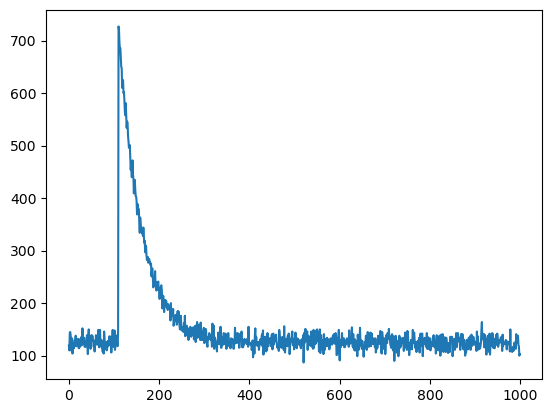

In [25]:
t = np.arange(1000)
gen = generator(t,600)
x = next(gen)
print(sum(x))
plt.plot(x)
bayesian_blocks(t,x,fitness=ExponentialBlocks_Events,ncp_prior=700)

In [5]:
def num_blocks(t,x,ncp_prior_list,fitness):
    arr = np.zeros_like(ncp_prior_list)
    for i in range(len(ncp_prior_list)):
        edg = bayesian_blocks(t,x,fitness=fitness,ncp_prior=ncp_prior_list[i])
        n_edges = len(edg)
        n_blocks = n_edges - 1
        #print(n_blocks)
        arr[i] = n_blocks
    return arr

In [6]:
def ncp_optimizer(t,gamma,ncp_prior_list,fitness,n_iter=10):
    gen = generator(t,gamma)
    arr = np.zeros((n_iter,len(ncp_prior_list)))
    for i in tqdm(range(n_iter)):
        x = next(gen)
        arr[i] = num_blocks(t,x,ncp_prior_list,fitness)
    arr[arr != 3] = 1
    arr[arr == 3] = 0
    mean_array = np.mean(arr,axis=0)
    return mean_array
    #tmp = np.where(mean_array < p_0)[0]
    #if tmp.size == 0:
    #    return None,mean_array
    #opt_index = tmp[0]
    #return ncp_prior_list[opt_index],mean_array

In [7]:
t=np.arange(500)
gamma=600
ncp_prior_list = np.linspace(1000,1100,2)
#num_blocks(t,x,ncp_prior_list,fitness = ExponentialBlocks_Events_Alt_2)
#ncp_optimizer(t,gamma,ncp_prior_list,0.1,fitness = ExponentialBlocks_Events_Alt_2,n_iter=10)

In [8]:
'''
gammas = np.linspace(389.47368421052636,2000,18)
ncp_prior_list = np.linspace(400,1600,20)
t = np.arange(500)
n_iter = 50

#columns = ['gamma'] + ['p_0(ncp='+str(ncp)+')' for ncp in ncp_prior_list] + ['n_iter']
#df = pd.DataFrame(columns = columns)
df = pd.read_csv('ncp.csv')
for gamma in gammas:
    print(f'esecuzione con parametro gamma={gamma}')
    p_0_array = ncp_optimizer(t,gamma,ncp_prior_list,fitness = ExponentialBlocks_Events_Alt_2,n_iter=n_iter)
    df.loc[len(df)] = np.concatenate([np.array([gamma]),p_0_array,np.array([n_iter])])
    df.to_csv('ncp.csv', index = False)
'''

"\ngammas = np.linspace(389.47368421052636,2000,18)\nncp_prior_list = np.linspace(400,1600,20)\nt = np.arange(500)\nn_iter = 50\n\n#columns = ['gamma'] + ['p_0(ncp='+str(ncp)+')' for ncp in ncp_prior_list] + ['n_iter']\n#df = pd.DataFrame(columns = columns)\ndf = pd.read_csv('ncp.csv')\nfor gamma in gammas:\n    print(f'esecuzione con parametro gamma={gamma}')\n    p_0_array = ncp_optimizer(t,gamma,ncp_prior_list,fitness = ExponentialBlocks_Events_Alt_2,n_iter=n_iter)\n    df.loc[len(df)] = np.concatenate([np.array([gamma]),p_0_array,np.array([n_iter])])\n    df.to_csv('ncp.csv', index = False)\n"

In [9]:
def mult_helper(t,gamma,ncp_prior_list,fitness,n_iter):
    #print(gamma)
    p_0_array = ncp_optimizer(t,gamma,ncp_prior_list,fitness = fitness,n_iter=n_iter)
    return np.concatenate([np.array([gamma]),p_0_array,np.array([n_iter])])

In [ ]:
gammas = np.linspace(400,2000,5)
ncp_prior_list = np.linspace(400,2000,4)
t = np.arange(1000)
n_iter = 1

if os.path.exists('ncp.csv'):
    df = pd.read_csv('ncp.csv')
else:
    columns = ['gamma'] + ['p_0(ncp='+str(ncp)+')' for ncp in ncp_prior_list] + ['n_iter']
    df = pd.DataFrame(columns = columns)

data = zip(repeat(t),gammas,repeat(ncp_prior_list),repeat(ExponentialBlocks_Events),repeat(n_iter))

with Pool(5) as p:
    results = p.starmap(mult_helper,data)
print(results)
for row in results:
    df.loc[len(df)] = row
df.to_csv('ncp.csv',index = False)

Tempo di Calcolo: 17.423430681228638
Estremi: [  0.  107.5 219.5 999. ]
Blocco 0: a=-0.001290015240742729,gamma=117.96822361890985
Blocco 1: a=-0.005154786025772113,gamma=122.16514573978738
Blocco 2: a=-4.657900052208626e-05,gamma=123.40392732786205


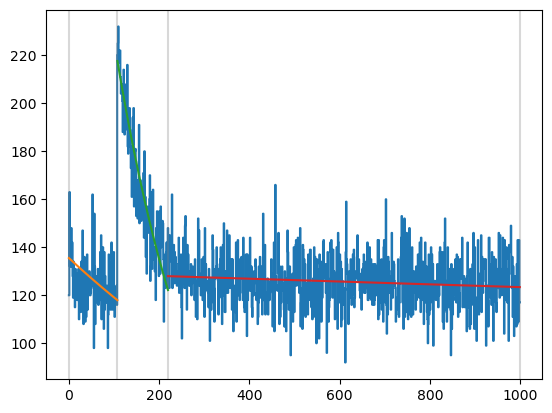

Tempo di Calcolo: 21.272127866744995
Estremi: [  0.  121.5 231.5 999. ]
Blocco 0: a=-0.00044929150746283536,gamma=123.45703395062593
Blocco 1: a=-0.005214004838375967,gamma=122.80739960795985
Blocco 2: a=-4.8503912628586024e-05,gamma=123.63729470279489


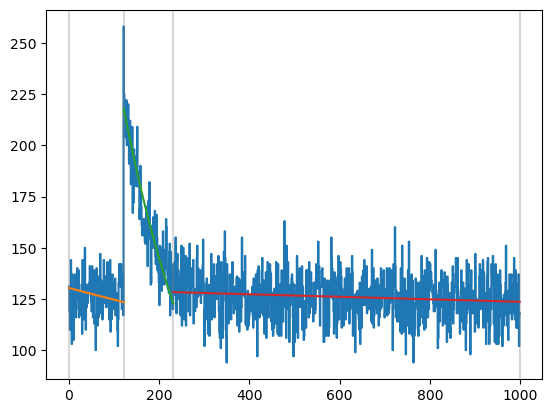

In [10]:
t = np.arange(1000)
gen = generator(t,100)
x = next(gen)
test_bb_exp(t,x,ExponentialBlocks_Events,ncp_prior=280)
x = next(gen)
test_bb_exp(t,x,ExponentialBlocks_Events,ncp_prior=280)